# SWE Results: introductory examples

In this notebook we generate all the "introductory example" plots for our paper _Exploring Model Misspecification in Shallow Water Equations via Statistical Finite Elements_.

If you see anything of interest or have any questions, please do get in touch (cpd32 `at` cam.ac.uk).

In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt

from tabulate import tabulate
import xarray as xr

import sys
sys.path.insert(0, "../src")
from swe import ShallowOne
from figures import figure_sizes, texp

import seaborn as sns
sns.set_palette("muted")
print(sns.color_palette("muted").as_hex())

DPI = 1000

['#4878d0', '#ee854a', '#6acc64', '#d65f5f', '#956cb4', '#8c613c', '#dc7ec0', '#797979', '#d5bb67', '#82c6e2']


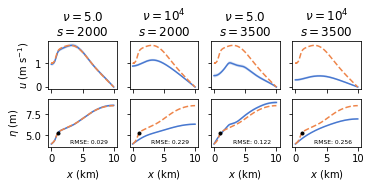

In [2]:
# HACK(connor) to get x-coords
swe = ShallowOne(
    control=dict(nx=500, dt=1., theta=0.6, simulation="tidal_flow"),
    params = dict(nu=1., shore_start=2000.,
                  shore_height=5.,
                  bump_height=0., bump_centre=8000., bump_width=400))


def plot_means_vars(output_files):
    """ Read in errors from output file. """
    n_models = len(output_files)
    fig, axs = plt.subplots(2, n_models,
                            constrained_layout=True,
                            figsize=(0.7 * figure_sizes["fullwidth"], 2.5),
                            sharey="row", sharex=True)
    
    for col, file in enumerate(output_files):
        checkpoint = h5py.File(file, "r")
        nu = checkpoint["/"].attrs["nu"]
        nt_skip = checkpoint["/"].attrs["nt_skip"]
        s = checkpoint["/"].attrs["s"]
        assert checkpoint["/"].attrs["rho_h"] == 2e-3

        idx_plot = 70
        t_plot = checkpoint["/t"][idx_plot]
        u_mean = checkpoint["/u_mean"][idx_plot, :]
        u_var = checkpoint["/u_var"][idx_plot, :]
        h_mean = checkpoint["/h_mean"][idx_plot, :]
        h_var = checkpoint["/h_var"][idx_plot, :]
        rmse_rel = np.mean(checkpoint["/rmse"][:])  # average RMSE for comparison?
        checkpoint.close()
        
        # get and read in data
        dgp = xr.open_dataset("../data/h_shore_dgp.nc")
        idx_obs = np.abs(t_plot - dgp.coords["t"].values[:]).argmin()
        x_dgp = dgp.coords["x"].copy() / 1000
        u_dgp = dgp["u"].values[idx_obs, :]
        h_dgp = dgp["h"].values[idx_obs, :]

        dat = xr.open_dataset("../data/h_shore.nc")
        idx_obs = np.abs(t_plot - dat.coords["t"].values[:]).argmin()
        x_obs = 1.  # observed at 1km in
        y_obs = dat["h"].values[idx_obs, 50]  # dont include IC
        t_obs = dat.coords["t"].values[idx_obs]
        np.testing.assert_allclose(t_plot, t_obs)

        x_grid = swe.x_coords.copy()[:, 0]
        x_grid = x_grid / 1000
        axs[0, col].plot(x_grid, u_mean, label="Posterior")
        axs[0, col].fill_between(x_grid,
                                 u_mean - 1.96 * np.sqrt(u_var), 
                                 u_mean + 1.96 * np.sqrt(u_var),
                                 alpha=0.2)
        axs[0, col].plot(x_dgp, u_dgp, "--", label="Truth")
        num = texp(f"{nu:.1e}", dollar_surround=False)
        axs[0, col].set_title(fr"$\nu = {num}$" + "\n" + fr"$s = {s:.0f}$")
        axs[0, col].set_xticks([0, 5, 10])
    
        axs[1, col].plot(x_grid, h_mean)
        axs[1, col].fill_between(x_grid,
                                 h_mean - 1.96 * np.sqrt(h_var),
                                 h_mean + 1.96 * np.sqrt(h_var),
                                 alpha=0.2)
        axs[1, col].plot(x_dgp, h_dgp, "--")
        axs[1, col].plot(x_obs, y_obs, "o", color="black", markersize=3)
        axs[1, col].set_xlabel(r"$x$ (km)")
        axs[1, col].text(3, 4, f"RMSE: {rmse_rel:.3f}", fontsize=6)
    
    axs[0, 0].set_ylabel(r"$u$ (m s$^{-1}$)")
    axs[1, 0].set_ylabel(r"$\eta$ (m)")

files = ["../outputs/swe-tidal-sparse/nonlinear-posterior-s-2000.0-nx_obs-1-nt_skip-30-nu-5.00e+00-k-32.h5",
         "../outputs/swe-tidal-sparse/nonlinear-posterior-s-2000.0-nx_obs-1-nt_skip-30-nu-1.00e+04-k-32.h5",
         "../outputs/swe-tidal-sparse/nonlinear-posterior-s-3500.0-nx_obs-1-nt_skip-30-nu-5.00e+00-k-32.h5",
         "../outputs/swe-tidal-sparse/nonlinear-posterior-s-3500.0-nx_obs-1-nt_skip-30-nu-1.00e+04-k-32.h5"]

plot_means_vars(files)
plt.savefig("../figures/intro-example-means-vars.pdf")  # , dpi=DPI)

In [3]:
def get_errors(output_file):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    s = checkpoint["/"].attrs["s"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    t_obs = checkpoint["/t_obs"][:]
    rmse = checkpoint["/rmse"][:]
    rmse_rel = checkpoint["/rmse_rel"][:]
    
    # common coordinates across all
    coords=dict(t=t_obs / 3600,
                s=np.array([s]),
                nu=np.array([nu]))
    
    rmse_ds = xr.DataArray(data=rmse[:, np.newaxis, np.newaxis],
                           coords=coords,
                           name="rmse")
    rmse_rel_ds = xr.DataArray(data=rmse_rel[:, np.newaxis, np.newaxis],
                               coords=coords,
                               name="rmse_rel")
    return xr.merge([rmse_ds, rmse_rel_ds])


errors_ds = []
for file in files:
    e = get_errors(file)
    errors_ds.append(e)

errors_nonlinear = xr.merge(errors_ds)
errors_nonlinear = errors_nonlinear.reindex(nu=errors_nonlinear.nu[::-1])

print(errors_nonlinear)

<xarray.Dataset>
Dimensions:   (t: 1440, s: 2, nu: 2)
Coordinates:
  * t         (t) float64 0.0002778 0.008611 0.01694 ... 11.98 11.98 11.99
  * s         (s) float64 2e+03 3.5e+03
  * nu        (nu) float64 1e+04 5.0
Data variables:
    rmse      (t, s, nu) float64 0.02156 0.02156 0.02156 ... 0.3045 0.05467
    rmse_rel  (t, s, nu) float64 0.9986 0.9986 0.9986 ... 0.09497 0.01705


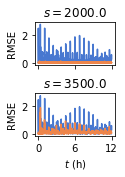

In [4]:
p = errors_nonlinear.rmse.plot(hue="nu", row="s",
                               figsize=(0.25 * figure_sizes["fullwidth"],  2.5),
                               sharex=True, sharey=True, add_legend=False)
# p.figlegend.set_title(r"$\nu$")
# plt.yscale("log")

errors_nonlinear.t
s_all =  errors_nonlinear.coords["s"].to_numpy()
labels = [
    fr"$s = {texp(f'{s:.1f}', False)}$" if s > 0 else "Linear" for s in s_all
]

for label, ax in zip(labels, p.axes.flat):
    ax.set_title(label)
    ax.set_ylabel("RMSE")

p.axes.flat[-1].set_xlabel(r"$t$ (h)")
plt.xticks([0, 6, 12])
plt.savefig("../figures/intro-example-rmse.pdf")  #, dpi=DPI)